## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import json


## Load US & IN CSV Data and Add Country Columns

In [2]:
df_us = pd.read_csv(r"C:\\Users\\kashi\\OneDrive\\Desktop\\Youtube Trending Analysis\\USvideos.csv")
df_us['country'] = 'US'

df_in = pd.read_csv(r"C:\\Users\\kashi\\OneDrive\\Desktop\\Youtube Trending Analysis\\INvideos.csv")
df_in['country'] = 'IN'


##  Combine the Two Datasets


In [3]:
df_combined = pd.concat([df_us, df_in], ignore_index=True)


## Load and Map Category IDs



In [4]:
with open(r"C:\\Users\\kashi\\OneDrive\\Desktop\\Youtube Trending Analysis\\US_category_id.json", "r") as f:
    category_data = json.load(f)

id_to_category = {}
for item in category_data['items']:
    id_to_category[int(item['id'])] = item['snippet']['title']

df_us['category'] = df_us['category_id'].map(id_to_category)
df_in['category'] = df_in['category_id'].map(id_to_category)
df_combined['category'] = df_combined['category_id'].map(id_to_category)


## Sentiment Analysis

In [5]:
analyzer = SentimentIntensityAnalyzer()

df_us['sentiment_score'] = df_us['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df_us['sentiment_label'] = df_us['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

df_in['sentiment_score'] = df_in['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df_in['sentiment_label'] = df_in['sentiment_score'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

df_combined = pd.concat([df_us, df_in], ignore_index=True)


## Drop Nulls, Duplicates, and Convert Dates

In [6]:
df_combined.dropna(inplace=True)
df_combined.drop_duplicates(inplace=True)

df_combined['trending_date'] = pd.to_datetime(df_combined['trending_date'], format='%y.%d.%m')
df_combined['publish_time'] = pd.to_datetime(df_combined['publish_time'])

print(df_combined.info())


<class 'pandas.core.frame.DataFrame'>
Index: 72894 entries, 0 to 78279
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                72894 non-null  object             
 1   trending_date           72894 non-null  datetime64[ns]     
 2   title                   72894 non-null  object             
 3   channel_title           72894 non-null  object             
 4   category_id             72894 non-null  int64              
 5   publish_time            72894 non-null  datetime64[ns, UTC]
 6   tags                    72894 non-null  object             
 7   views                   72894 non-null  int64              
 8   likes                   72894 non-null  int64              
 9   dislikes                72894 non-null  int64              
 10  comment_count           72894 non-null  int64              
 11  thumbnail_link          72894 non-null  object

## Visualizations



### 1. Top Categories (by ID)

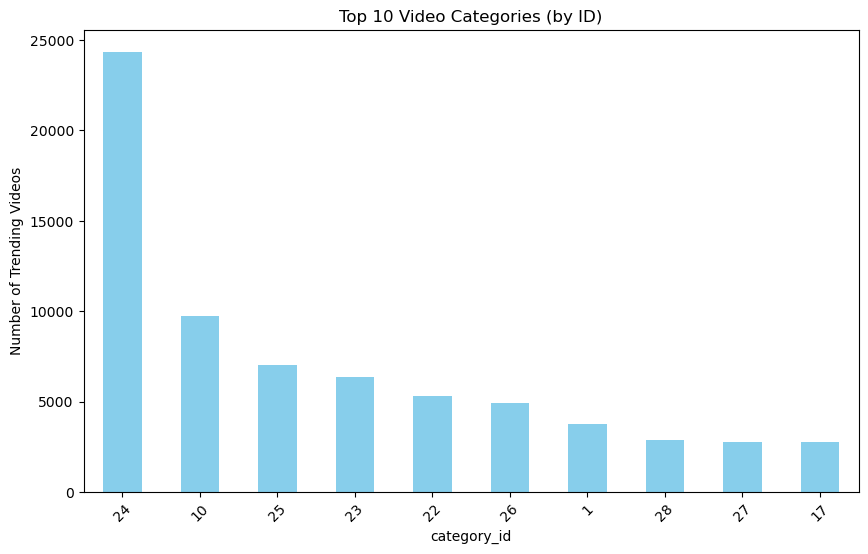

In [7]:
plt.figure(figsize=(10,6))
df_combined['category_id'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Video Categories (by ID)")
plt.xticks(rotation=45)
plt.ylabel("Number of Trending Videos")
plt.show()


### 2. Sentiment Distribution

C:\Users\kashi\AppData\Local\Temp\ipykernel_29728\2660739450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_combined, x='sentiment_label', palette='coolwarm')


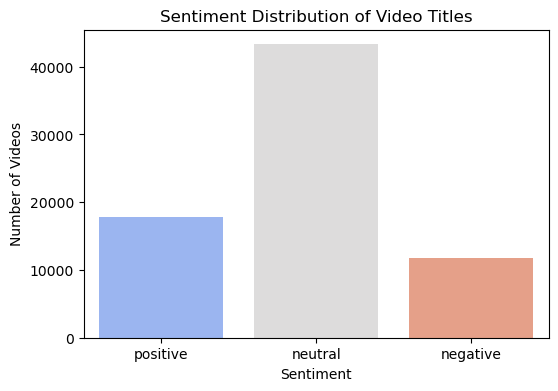

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_combined, x='sentiment_label', palette='coolwarm')
plt.title("Sentiment Distribution of Video Titles")
plt.xlabel("Sentiment")
plt.ylabel("Number of Videos")
plt.show()


### 3. Likes vs Dislikes



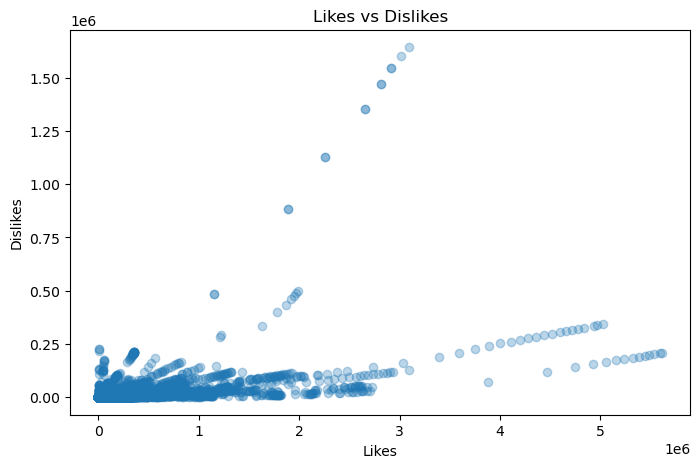

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(df_combined['likes'], df_combined['dislikes'], alpha=0.3)
plt.title("Likes vs Dislikes")
plt.xlabel("Likes")
plt.ylabel("Dislikes")
plt.show()


### 4. Top Categories by Average Views

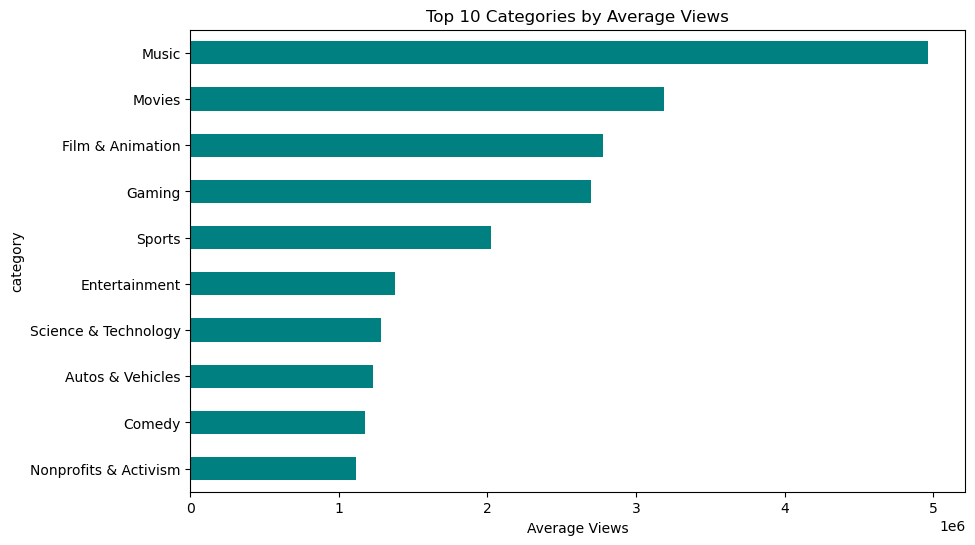

In [10]:
category_avg_views = df_combined.groupby('category')['views'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
category_avg_views.plot(kind='barh', color='teal')
plt.title("Top 10 Categories by Average Views")
plt.xlabel("Average Views")
plt.gca().invert_yaxis()
plt.show()


### 5. Average Views by Category per Country

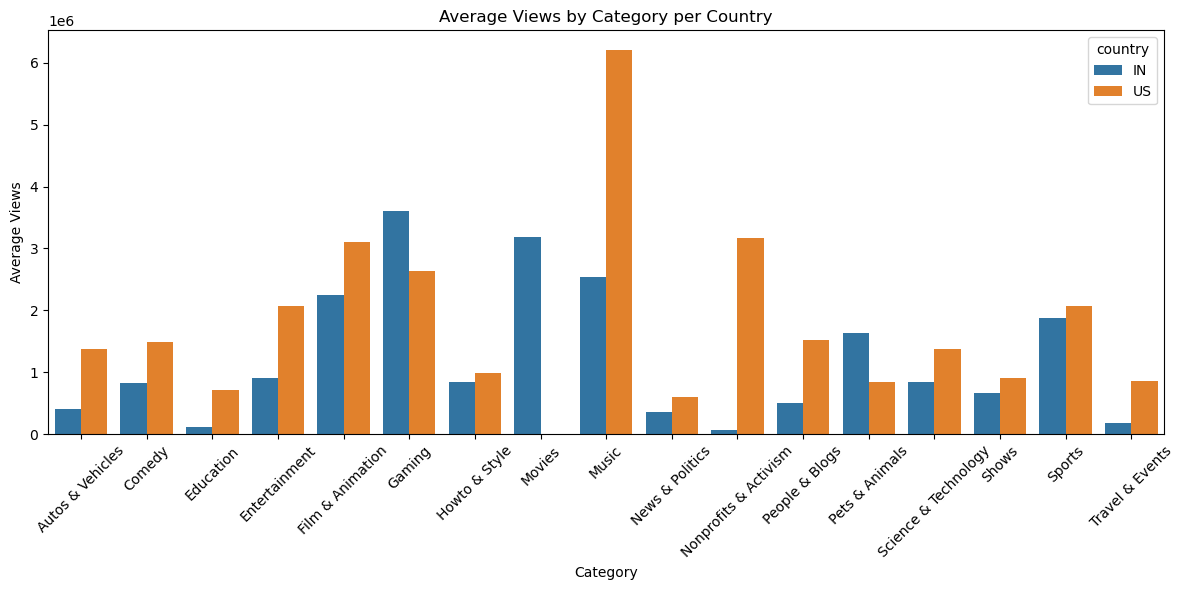

In [11]:
views_by_cat_country = df_combined.groupby(['country', 'category'])['views'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=views_by_cat_country, x='category', y='views', hue='country')
plt.title("Average Views by Category per Country")
plt.xlabel("Category")
plt.ylabel("Average Views")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 6. Sentiment Comparison US vs IN

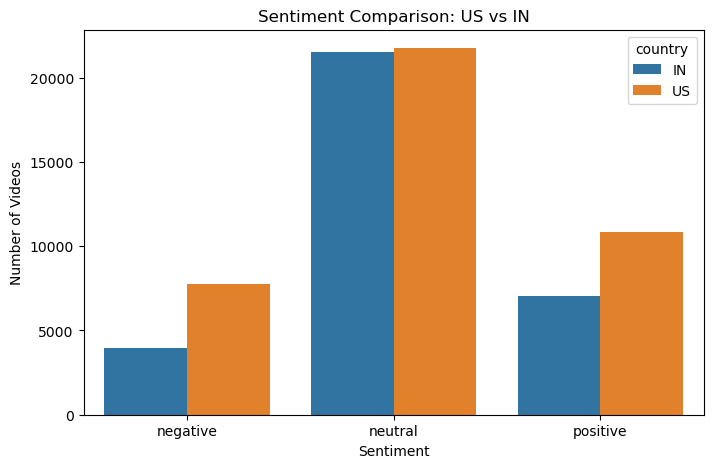

In [12]:
sentiment_comparison = df_combined.groupby(['country', 'sentiment_label']).size().reset_index(name='count')

plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_comparison, x='sentiment_label', y='count', hue='country')
plt.title("Sentiment Comparison: US vs IN")
plt.xlabel("Sentiment")
plt.ylabel("Number of Videos")
plt.show()


## Export Cleaned Dataset

In [13]:
df_combined.to_csv(r"C:\\Users\\kashi\\Downloads\\youtube_cleaned.csv", index=False, encoding='utf-8', quoting=1)
